# cNMF in `cellarium-ml`

Stephen Fleming, Yang Xu

2025.07.31

The `cellarium-ml` project:

https://github.com/cellarium-ai/cellarium-ml

The specific implementation of cNMF we are actively working on:

https://github.com/cellarium-ai/cellarium-ml/pull/196

## Overview

`cellarium-ml` implements a variety of algorithms in a way that is scalable to hundreds of millions of cells and beyond.
This notebook provides a demo run of Cellarium's implementation of consensus NMF (cNMF).
The specific algorithm for NMF is based on "Online learning for matrix factorization and sparse coding" by Mairal, Bach, Ponce, and Sapiro (JMLR 2010).

## This notebook

This notebook shows an end-to-end cNMF run in `cellarium-ml`, starting with h5ad files and ending with results.
There are several steps involved.

## Description of analysis steps

1. Compute highly-variable genes.

2. Run cNMF on selected highly-variable genes.

3. Interactive plotting in this notebook to help determine optimal number of programs `k`, and a 
   `density_threshold` and `local_neighborhood_size` for the consensus step.

4. Computing consensus factors.

5. (Optional) Computing per-cell factor loadings.

6. (Optional) Re-computing the `k` factor definitions using all genes (not just highly-variable genes).

## Inputs

- a lits of filepaths to h5ad files: can be local or in a google bucket (or at some URL)
    - ideally the h5ad files would be from an extracted curriculum from `cellarium-nexus`, but these files can be any h5ad files
        - until [#324](https://github.com/cellarium-ai/cellarium-ml/issues/324) is resolved, the h5ad files
          should be limited in size to what can fit in memory

## Outputs (work in progress... not complete)

- anndata object for all cells (with an empty count matrix) containing:
    - `adata.obsm["X_cnmf_k20"]`: (cell, k) matrix of per-cell factor loadings (for the `k = 20` decomposition)
    - `adata.obsp["cnmf_k20_factors_hvg"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - from the initial cNMF fit: all non-highly-variable genes have weight zero
    - `adata.obsp["cnmf_k20_factors_hvg_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - `adata.obsp["cnmf_k20_factors"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - computed by refitting cell loadings from `adata.obsp["cnmf_k20_factors_hvg"]` by refitting the dataset including all genes
    - `adata.obsp["cnmf_k20_factors_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - (optionally): all of the above for other choices of `k` as well

NOTE: You will need to use the `nmf_sf_singlenotebook` branch of `cellarium-ml` on github

In [1]:
import cellarium.ml.preprocessing
import cellarium.ml.data
import cellarium.ml.transforms
import cellarium.ml.api
import cellarium.ml.models

import lightning.pytorch as pl
import numpy as np

/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Data

In [3]:
# the data

# CZI dataset is PBMCs from https://cellxgene.cziscience.com/e/59b69042-47c2-47fd-ad03-d21beb99818f.cxg/

h5ad_paths = [
    "https://datasets.cellxgene.cziscience.com/a06a1d9e-b1e8-452a-bf83-8ef6ec1044ec.h5ad"
    # "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_0.h5ad",
    # "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_1.h5ad",
    # "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_2.h5ad",
]

In [4]:
# for demonstration purposes: automatically grab h5ad file paths from a bucket prefix, like data from Nexus

try:
    example_cellarium_curriculum_h5ad_paths = cellarium.ml.api.h5ad_paths_from_google_bucket(
        "gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files"
    )
    print("Example of how to grab files from a Nexus curriculum bucket path:")
    print(f"[{example_cellarium_curriculum_h5ad_paths[0]}, ...]")
except:
    pass

Example of how to grab files from a Nexus curriculum bucket path:
[gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files/extract_0.h5ad, ...]


## Cellarium data setup

For this demo we are using the python API for cellarium.  It's also possible to use command line versions of these tools.

In [5]:
h5ad_paths

['https://datasets.cellxgene.cziscience.com/a06a1d9e-b1e8-452a-bf83-8ef6ec1044ec.h5ad']

(For remote files over the internet, this next cell can take a minute.)

In [6]:
datamodule = cellarium.ml.CellariumAnnDataDataModule(
    dadc=cellarium.ml.data.DistributedAnnDataCollection(
        filenames=h5ad_paths,
        limits=np.cumsum(cellarium.ml.api.get_h5ad_files_n_cells(h5ad_paths))
    ),
    batch_keys={
        "x_ng": cellarium.ml.utilities.data.AnnDataField(attr="X", convert_fn=cellarium.ml.utilities.data.densify),
        "var_names_g": cellarium.ml.utilities.data.AnnDataField(attr="var_names"),
        "obs_names_n": cellarium.ml.utilities.data.AnnDataField(attr="obs_names"),
    },
    batch_size=1024,
    shuffle=True,
    train_size=1.0,
)

datamodule.setup(stage="fit")

# Highly variable genes

## Run onepass model

This computes mean and variance per gene.

In [7]:
# get gene names to use later (and assume all files have the same genes)

var_names_g = cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0])
var_names_g[:3]

array(['ENSG00000161920', 'ENSG00000272622', 'ENSG00000122335'],
      dtype='<U15')

In [8]:
# set up the model that will be used to compute mean and var of each gene

onepass_module = cellarium.ml.CellariumModule(
    transforms=[
        cellarium.ml.transforms.NormalizeTotal(),
        cellarium.ml.transforms.Log1p(),
    ],
    model=cellarium.ml.models.OnePassMeanVarStd(
        var_names_g=cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0]),
    )
)

In [9]:
trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=1,
    default_root_dir="tmp/onepass",
)
trainer.fit(onepass_module, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train


Epoch 0: 100%|██████████| 48/48 [00:05<00:00,  8.46it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 48/48 [00:05<00:00,  8.44it/s, v_num=16]



In [10]:
# the onepass model computes a mean and variance per gene

mean_g = trainer.model.model.mean_g
var_g = trainer.model.model.var_g

## Compute hvgs

You can choose `n_top_genes` to suit your needs.

In [11]:
var = cellarium.ml.preprocessing.get_highly_variable_genes(
    gene_names=var_names_g,
    mean=mean_g,
    var=var_g,
    n_top_genes=2000,
)
var

means  dispersions         mean_bin  dispersions_norm  \
ENSG00000161920  0.244389     0.308106      (0.24, 0.3]          0.109413   
ENSG00000272622  0.000359     0.772813  (-0.0012, 0.06]          2.275874   
ENSG00000122335  0.047809     0.471847  (-0.0012, 0.06]         -0.021823   
ENSG00000175548  0.039010     0.430394  (-0.0012, 0.06]         -0.338290   
ENSG00000176340  0.832542    -0.631454     (0.78, 0.84]         -1.340732   
...                   ...          ...              ...               ...   
ENSG00000259224  0.000335     0.340102  (-0.0012, 0.06]         -1.027617   
ENSG00000248991  0.028386     0.385193  (-0.0012, 0.06]         -0.683375   
ENSG00000106780  0.293624     0.237828      (0.24, 0.3]         -0.728343   
ENSG00000223734  0.001630     0.474816  (-0.0012, 0.06]          0.000845   
ENSG00000260456  0.012795     0.482930  (-0.0012, 0.06]          0.062792   

                 highly_variable  
ENSG00000161920            False  
ENSG00000272622             True  
ENSG00000122335            False  
ENSG00000175548            False  
ENSG00000176340            False  
...                          ...  
ENSG00000259224            False  
ENSG00000248991            False  
ENSG00000106780            False  
ENSG00000223734            False  
ENSG00000260456            False  

[22827 rows x 5 columns]

In [12]:
var['highly_variable'].sum()

2000

In [13]:
# the highly variable genes

hvg_var_names_g = var.index[var['highly_variable']]
hvg_var_names_g

Index(['ENSG00000272622', 'ENSG00000181240', 'ENSG00000168229',
       'ENSG00000263677', 'ENSG00000148498', 'ENSG00000162894',
       'ENSG00000164692', 'ENSG00000163131', 'ENSG00000187837',
       'ENSG00000181896',
       ...
       'ENSG00000089472', 'ENSG00000164483', 'ENSG00000180532',
       'ENSG00000235531', 'ENSG00000120693', 'ENSG00000138835',
       'ENSG00000271717', 'ENSG00000204310', 'ENSG00000254614',
       'ENSG00000256576'],
      dtype='object', length=2000)

# cNMF

## Run NMF

Set things up to run cNMF in cellarium.

In [14]:
# user's choice for the number of components: must input a python list

# k_values = [10, 20, 30]
k_values = list(range(3, 20))

In [15]:
# user's choice for the number of NMF replicates that should go into consensus

nmf_replicates = 100

In [16]:
# get set up for training

nmf_model = cellarium.ml.models.NonNegativeMatrixFactorization(
    full_g=len(var_names_g),
    var_names_hvg=hvg_var_names_g,
    k_values=k_values,
    r=nmf_replicates,
)

nmf_module = cellarium.ml.CellariumModule(
    cpu_transforms=[cellarium.ml.transforms.Filter(filter_list=hvg_var_names_g)],
    model=nmf_model,
)

datamodule.setup(stage="fit")

trainer_nmf = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=5,  # this is up for debate, but empirically 5 seems to be enough
    default_root_dir="tmp/nmf",
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
# train on the data

pl.seed_everything(0)  # not required but helps make this notebook reproducible

trainer_nmf.fit(nmf_module, datamodule)

Seed set to 0

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 48/48 [01:33<00:00,  0.51it/s, v_num=33]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 48/48 [01:34<00:00,  0.51it/s, v_num=33]



In [18]:
# see the shape of the NMF gene programs that have been inferred: [replicates, k, genes]

for k in nmf_model.k_values:
    print(getattr(nmf_model, f"D_{k}_rkg").shape)

torch.Size([100, 3, 2000])
torch.Size([100, 4, 2000])
torch.Size([100, 5, 2000])
torch.Size([100, 6, 2000])
torch.Size([100, 7, 2000])
torch.Size([100, 8, 2000])
torch.Size([100, 9, 2000])
torch.Size([100, 10, 2000])
torch.Size([100, 11, 2000])
torch.Size([100, 12, 2000])
torch.Size([100, 13, 2000])
torch.Size([100, 14, 2000])
torch.Size([100, 15, 2000])
torch.Size([100, 16, 2000])
torch.Size([100, 17, 2000])
torch.Size([100, 18, 2000])
torch.Size([100, 19, 2000])


## Set up to explore outputs

We have a helper class that facilitates downstream analysis steps. Here we instantiate it and use it to get various outputs.

In [19]:
from cellarium.ml.models.nmf import NMFOutput

nmf_output = NMFOutput(
    nmf_module=nmf_module,
    datamodule=datamodule,
)

In [20]:
nmf_output

NMFOutput(
    nmf_module=CellariumModule(pipeline = CellariumPipeline(
          (0): Filter(filter_list=['ENSG00000272622' 'ENSG00000181240' 'ENSG00000168229' ...
           'ENSG00000204310' 'ENSG00000254614' 'ENSG00000256576'])
          (1): NonNegativeMatrixFactorization(
            (transform__filter_to_hvgs): Filter(filter_list=['ENSG00000272622' 'ENSG00000181240' 'ENSG00000168229' ...
             'ENSG00000204310' 'ENSG00000254614' 'ENSG00000256576'])
          )
        )),
    datamodule={Train dataloader: size=48}
        {Validation dataloader: size=0}
        {Test dataloader: None}
        {Predict dataloader: None}
)
with consensus []

## Default k-selection plot

This is what Kotliar cNMF would produce with default values for `local_neighborhood_size=0.3` and `density_threshold=0.5`

cellarium.ml.models.nmf:cNMF - INFO - Computing consensus factors with default hyperparameters...
cellarium.ml.models.nmf:cNMF - INFO - Calculating reconstruction error (requires an entire pass through the data)...
cellarium.ml.models.nmf:cNMF - INFO - Calculating reconstruction error (requires an entire pass through the data)...


100%|██████████| 48/48 [00:09<00:00,  4.82it/s]



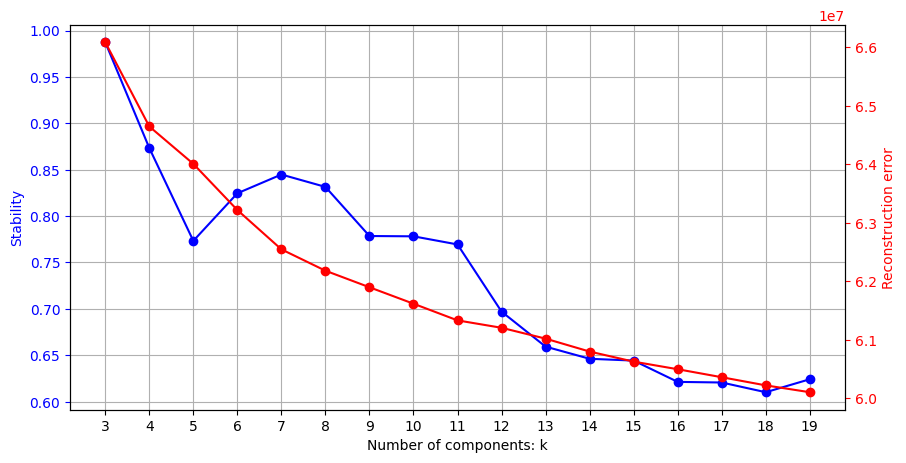

In [21]:
nmf_output.default_k_selection_plot()

## Compute consensus factors

This step requires hyperparamter choices.

The way the Kotliar cNMF demo notebook works, you first select a `k` of interest and make these choices for that particular `k`.

Let's start by picking a k-value and looking at what Kotliar calls the "local density histogram".

In [22]:
best_k = 7

### Density histograms

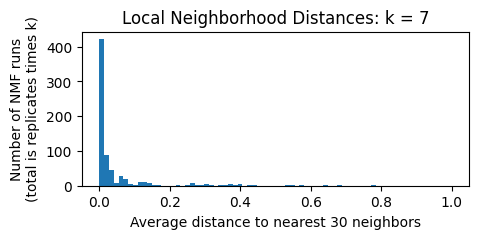

In [23]:
nmf_output.plot_density_histograms(k_values=[best_k], local_neighborhood_size=0.3)

In [24]:
# (optional) re-compute consensus D for certain k-values, given hyperparamter choices

density_threshold = 0.1  # change this threshold if desired based on the histogram above: idea is to remove outliers
local_neighborhood_size = 0.3  # this is a default that Kotliar leaves fixed in tutorials

nmf_output.compute_consensus_factors(
    k_values=[best_k],
    density_threshold=density_threshold,
    local_neighborhood_size=local_neighborhood_size,
)

In [25]:
# one key for each k-value

nmf_output.consensus.keys()

dict_keys([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [26]:
# each k-value has a few things computed: these get updated if you re-compute consensus for a particular k value

list(nmf_output.consensus[best_k].keys())

['filtered_euclidean_distance_matrix',
 'filtered_neighbor_distances',
 'all_neighbor_distances',
 'n_neighbors',
 'consensus_D_kg',
 'stability',
 'local_neighborhood_size',
 'density_threshold']

In [27]:
# the shape of the consensus matrix for a particular k

nmf_output.consensus[best_k]['consensus_D_kg'].shape

torch.Size([7, 2000])

### Create clustermap plots

Here we again experiment with different `density_threshold` values. Plotting the clustermap with different `density_threshold` values actually re-computes consensus for that particular `k`.

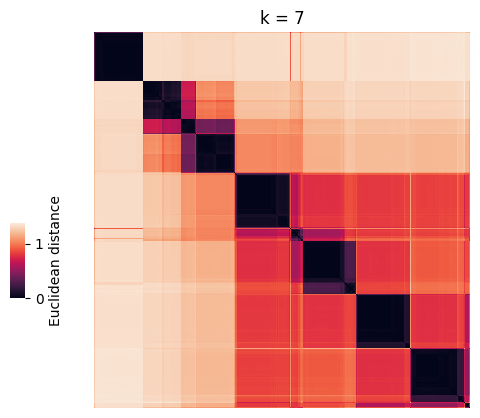

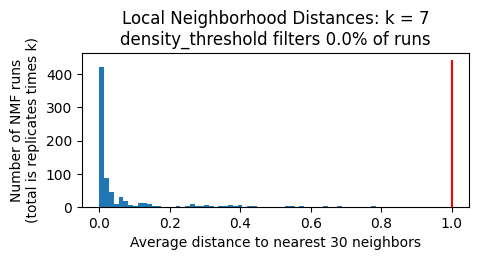

In [28]:
nmf_output.plot_clustermap(k=best_k, density_threshold=1.0)

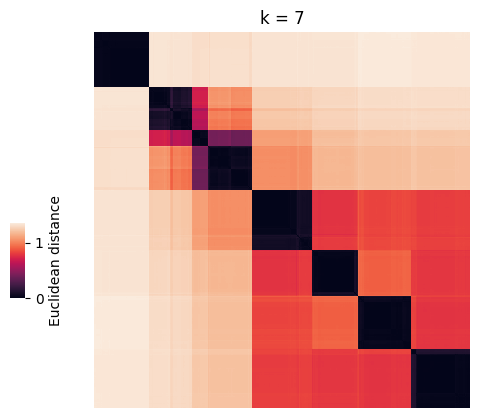

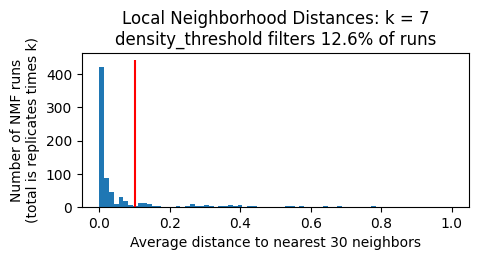

In [30]:
nmf_output.plot_clustermap(k=best_k, density_threshold=0.1)

## Compute reconstruction error at each k

Demonstration here in case you ever want to run this separately, but it gets run automatically as part of `nmf_output.default_k_selection_plot()`.

Technically the reconstruction error does depend on hyperparamter choices, because it depends on the consensus programs.

In [31]:
# we need to calculate the reconstruction error by going through the whole dataset: this can take time

nmf_output.calculate_reconstruction_error()

100%|██████████| 48/48 [00:10<00:00,  4.77it/s]



{3: 65972320.75,
 4: 64530701.75,
 5: 63894234.625,
 6: 63104473.125,
 7: 62436226.75,
 8: 62070220.375,
 9: 61787034.25,
 10: 61506954.0,
 11: 61221903.75,
 12: 61095327.25,
 13: 60909271.0,
 14: 60689381.25,
 15: 60516610.5,
 16: 60385742.0,
 17: 60247803.375,
 18: 60111561.0,
 19: 59996362.875}

## Other versions of the k-selection plot

Kotliar does not demo this, but the k-selection plot itself depends on the values of `density_threshold` and `local_neighborhood_size`.

In principle, you could choose different hyperparameters for each `k`, run `nmf_output.compute_consensus_factors(k, <your selected params here>)` on all the `k`, and then re-run `nmf_output.calculate_reconstruction_error()` and re-create the k-selection plot.

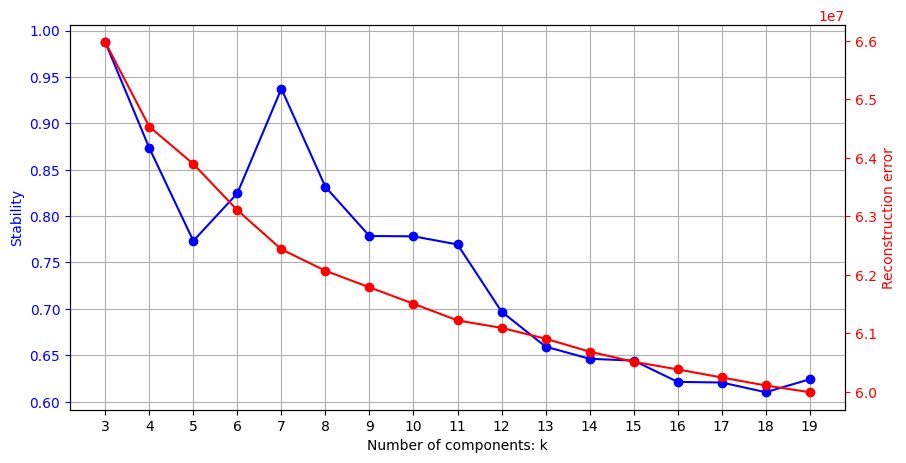

In [32]:
nmf_output.k_selection_plot()

See how the stability skyrocketed for `k=best_k` after we filtered at a different threshold?  :)

Different thresholds for different `k` hardly seems fair... unless you were to optimize the threshold for each `k` individually...

### Down a rabbit hole

You know, one guiding principle for this process could be the following... for each `k`, automatically choose a (reasonable) `density_threshold` that maximizes the stability for the given `k`. Let's try it.

cellarium.ml.models.nmf:cNMF - INFO - Computing consensus factors, searching for best density thresholds...


  0%|          | 0/17 [00:00<?, ?it/s]

cellarium.ml.models.nmf:cNMF - WARNING - Unable to find local minima in k=3 density histogram... 'fast' mode will fall back to 'exhaustive'


 76%|███████▋  | 13/17 [00:59<00:28,  7.14s/it]

cellarium.ml.models.nmf:cNMF - WARNING - Unable to find local minima in k=16 density histogram... 'fast' mode will fall back to 'exhaustive'


 82%|████████▏ | 14/17 [01:53<01:03, 21.18s/it]

cellarium.ml.models.nmf:cNMF - WARNING - Unable to find local minima in k=17 density histogram... 'fast' mode will fall back to 'exhaustive'


100%|██████████| 17/17 [02:59<00:00, 10.56s/it]

cellarium.ml.models.nmf:cNMF - INFO - Computing reconstruction errors...



100%|██████████| 48/48 [00:14<00:00,  3.35it/s]



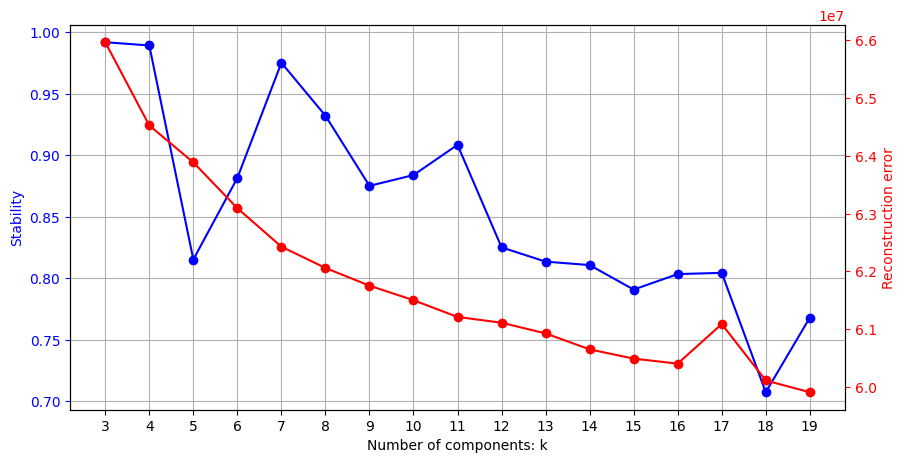

In [41]:
nmf_output.maximal_stability_k_selection_plot()

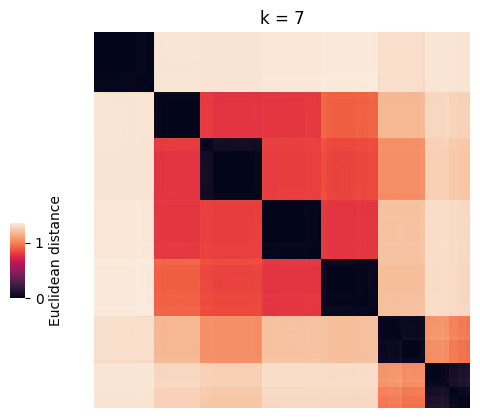

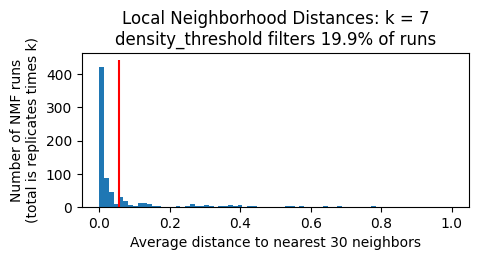

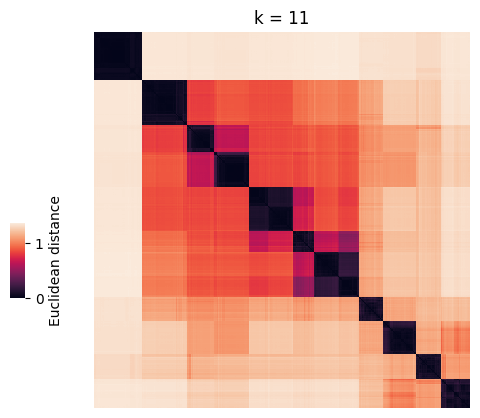

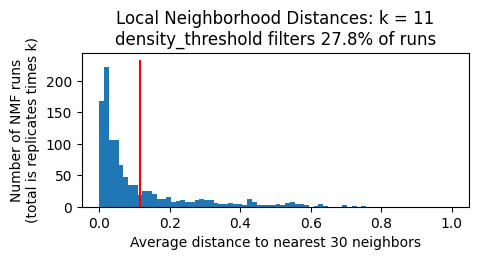

In [43]:
# visualize the results of this kind of automatic choosing of density_threshold
# note that the call to plot_clustermap() recomputes consensus, so it's important to specify the computed value

for k in [7, 11]:  # nmf_output.consensus:
    nmf_output.plot_clustermap(k=k, density_threshold=nmf_output.consensus[k]["density_threshold"])

(The strange thing about the stability metric is that it does not guarantee that there are actually `k` clusters.)

## Compute per-cell loadings

In [44]:
best_k

7

The loadings of each factor, computed for each cell.

In [45]:
# get per-cell factor loadings using the best k: this takes time
# `normalize` controls whether the per-cell loadings sum to 1

df = nmf_output.compute_loadings(k=best_k, normalize=True)

100%|██████████| 48/48 [00:04<00:00, 11.22it/s]


In [46]:
df.shape

(49139, 7)

In theory could add this information to the anndata object if you had a single object.
Here we will assume the dataset might be very large in total, so we will just try to open one h5ad file and add the annotations for those cells.

In [52]:
adata = cellarium.ml.data.read_h5ad_file(h5ad_paths[0])
adata.layers['counts'] = adata.raw.X.copy()
adata

AnnData object with n_obs × n_vars = 49139 × 22827
    obs: 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

In [53]:
# add cNMF loadings to obsm

adata.obsm["X_nmf"] = df.loc[adata.obs_names].values
adata.obsm["X_nmf"].shape

(49139, 7)

### Visualize factor loadings on a UMAP

Just for fun, if you have scanpy installed in your environment.

In [54]:
import scanpy as sc

In [79]:
sc.set_figure_params(figsize=(5, 5), fontsize=14, vector_friendly=True)

In [55]:
sc.pp.highly_variable_genes(adata, layer='counts', flavor='seurat_v3', n_top_genes=2000)

In [74]:
adata.X = adata.layers['counts'].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, method='umap', metric='cosine', n_pcs=10)
sc.tl.umap(adata)
adata.obsm["X_umap_counts"] = adata.obsm["X_umap"].copy()

In [104]:
# put these in obs for plotting

for k in range(adata.obsm["X_nmf"].shape[1]):
    adata.obs[f"nmf_{k}"] = adata.obsm["X_nmf"][:, k]

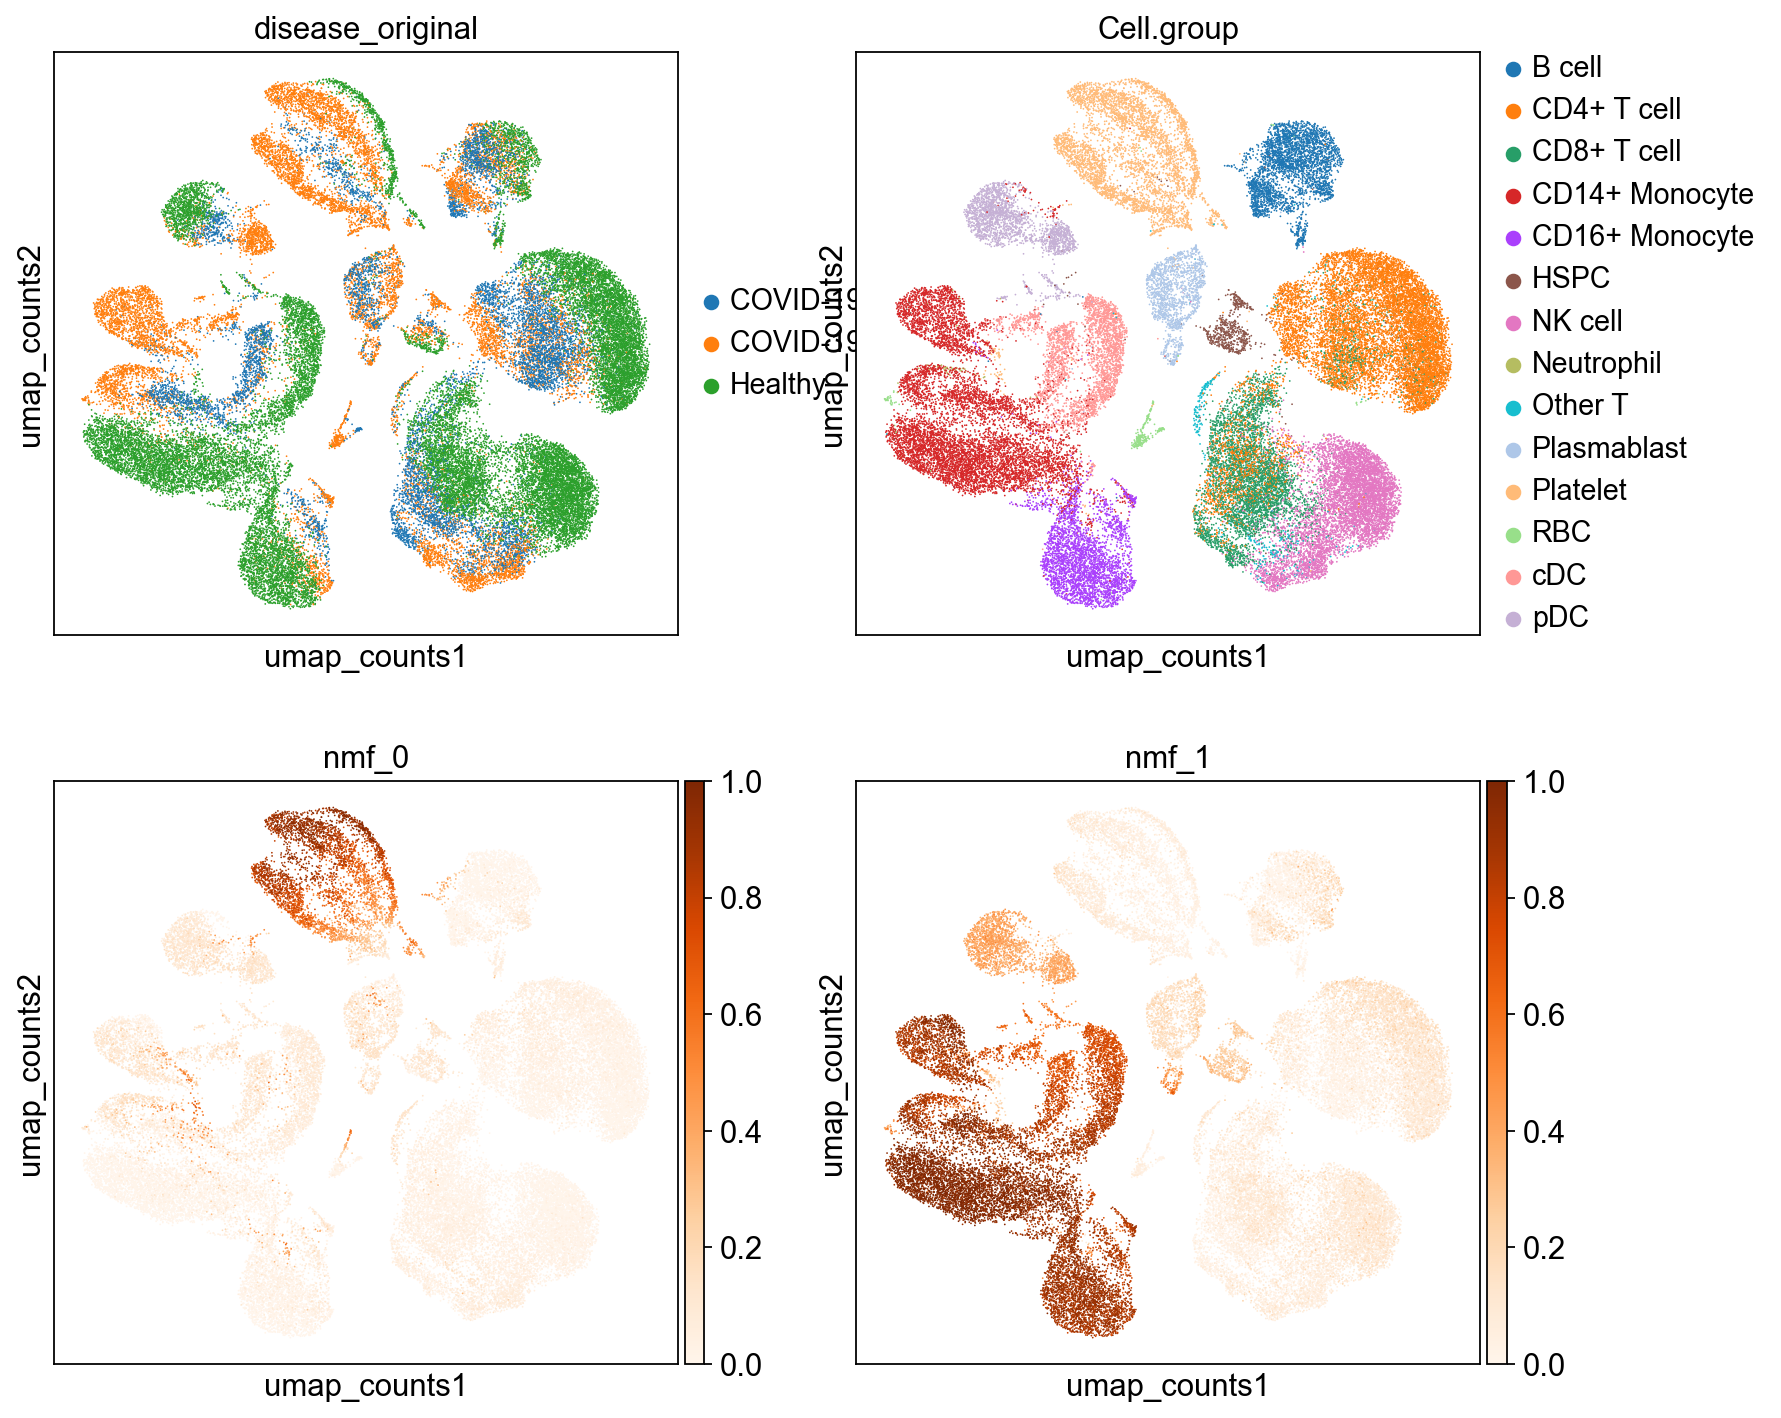

In [105]:
sc.pl.embedding(adata, basis='umap_counts', color=['disease_original', 'Cell.group', 'nmf_0', 'nmf_1'], color_map='Oranges', ncols=2)

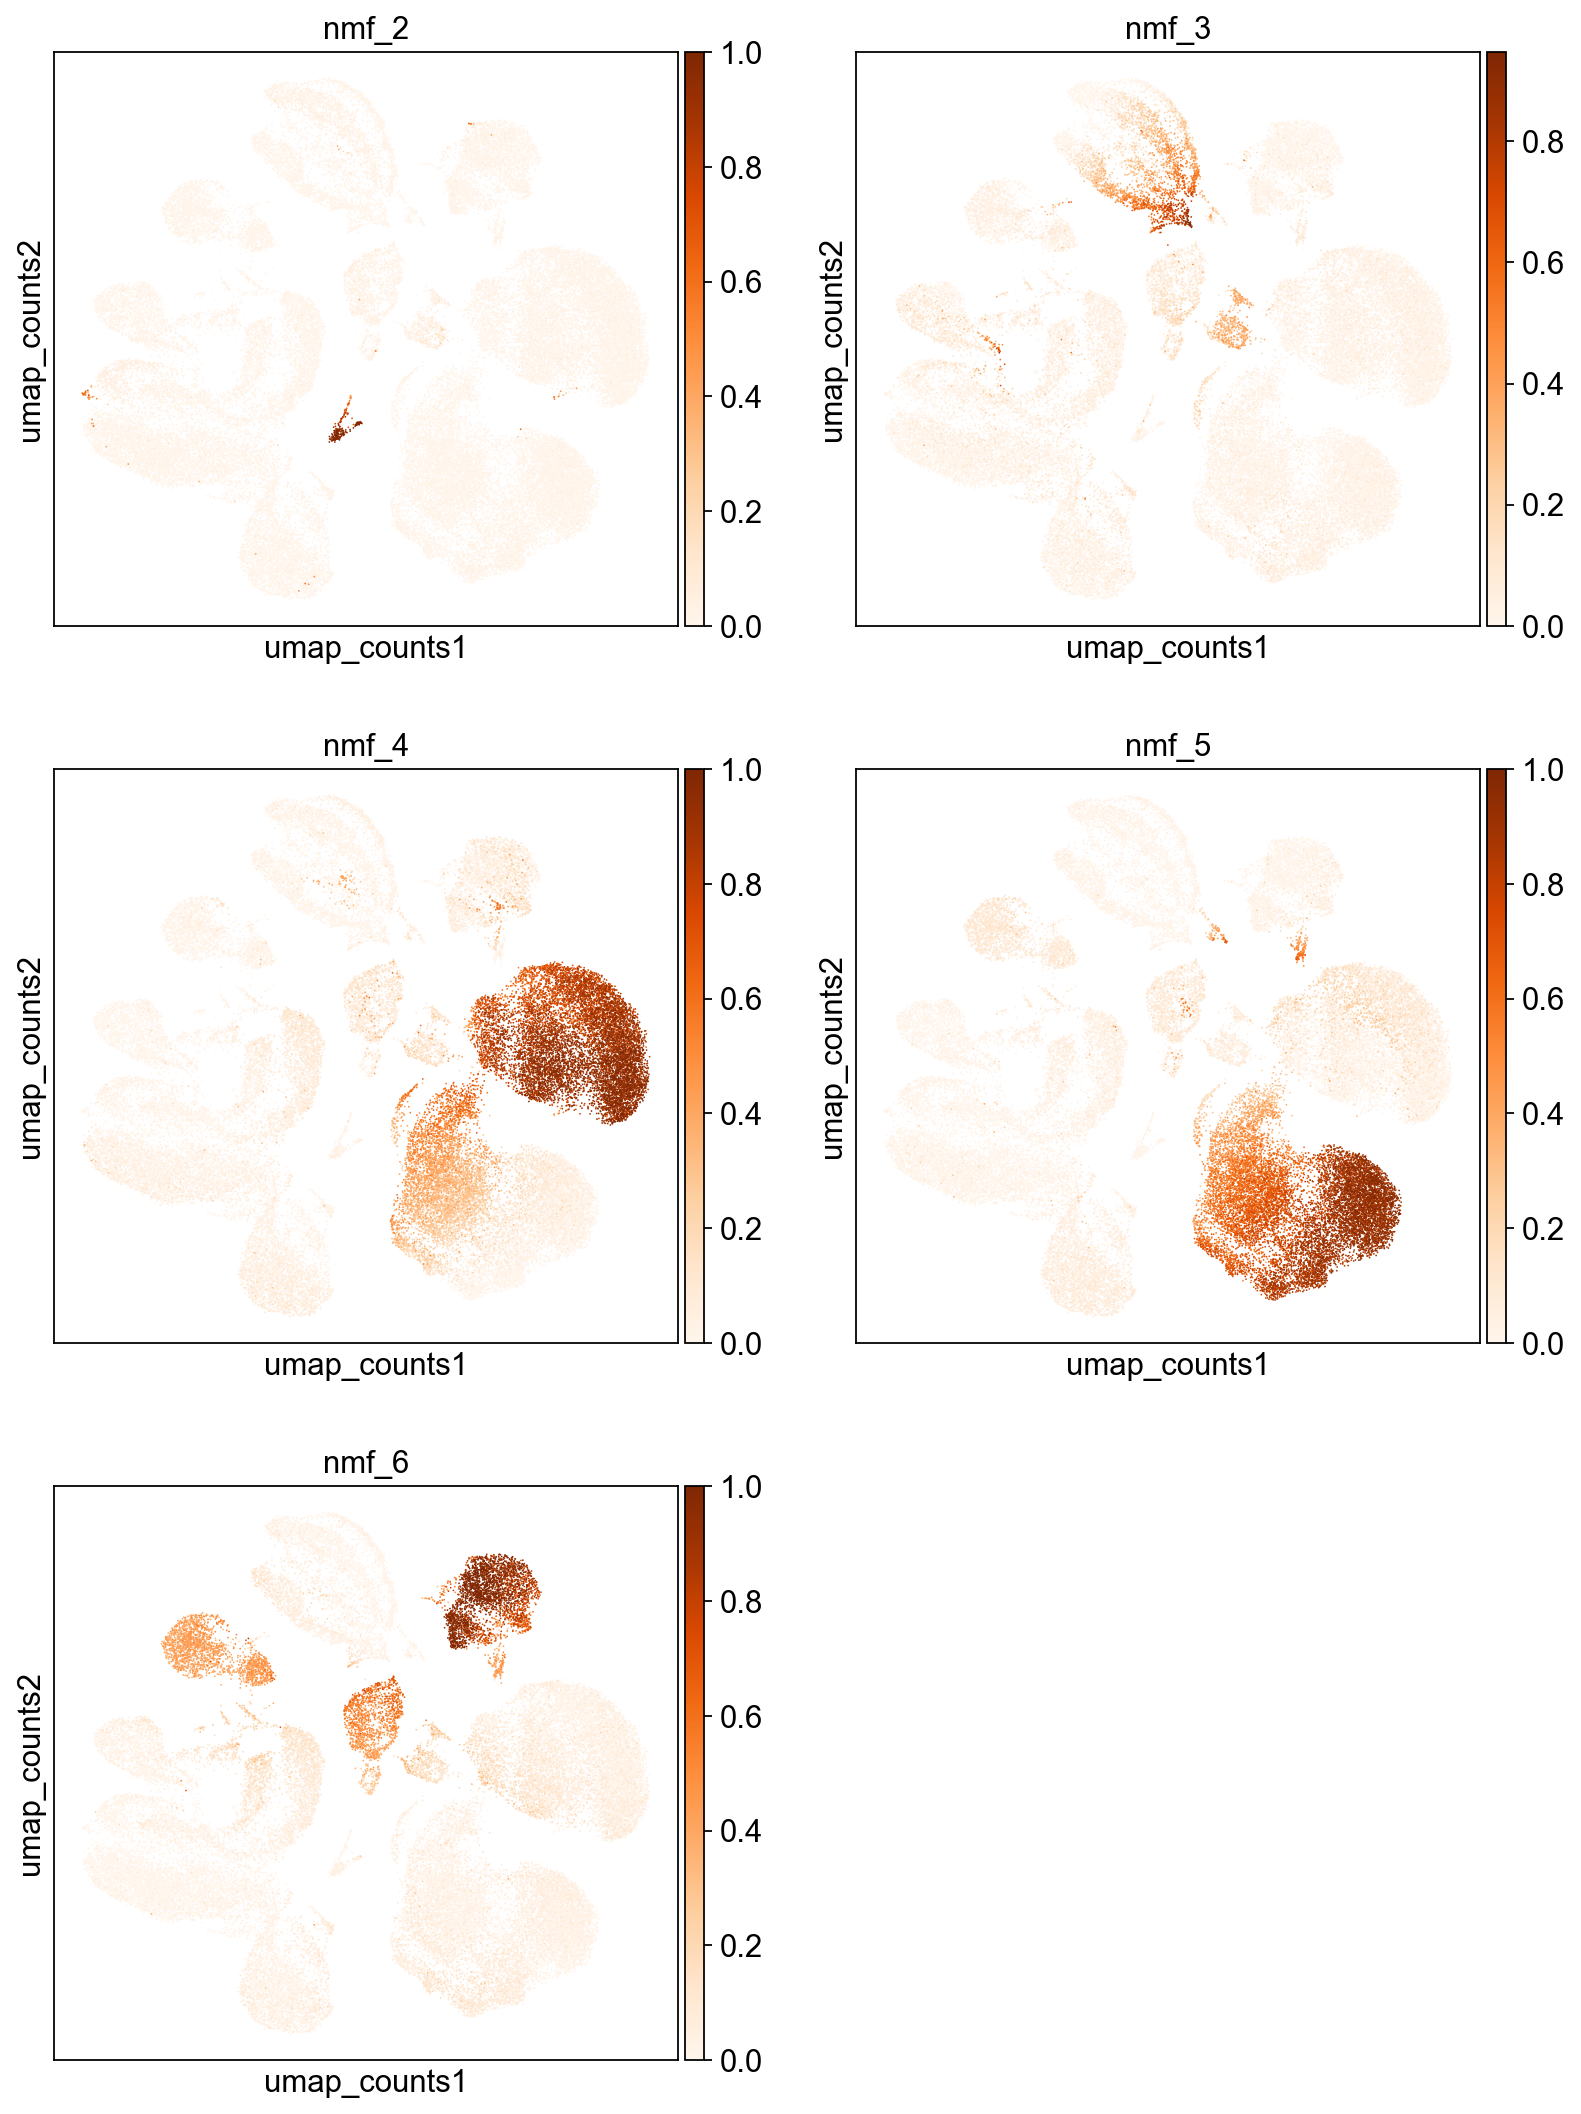

In [107]:
sc.pl.embedding(adata, basis='umap_counts', color=[f'nmf_{i}' for i in range(2, best_k)], color_map='Oranges', ncols=2)

In [83]:
# try a UMAP derived from the NMF components

sc.pp.neighbors(adata, use_rep='X_nmf', method='umap', metric='cosine')
sc.tl.umap(adata)
adata.obsm["X_umap_nmf"] = adata.obsm["X_umap"].copy()

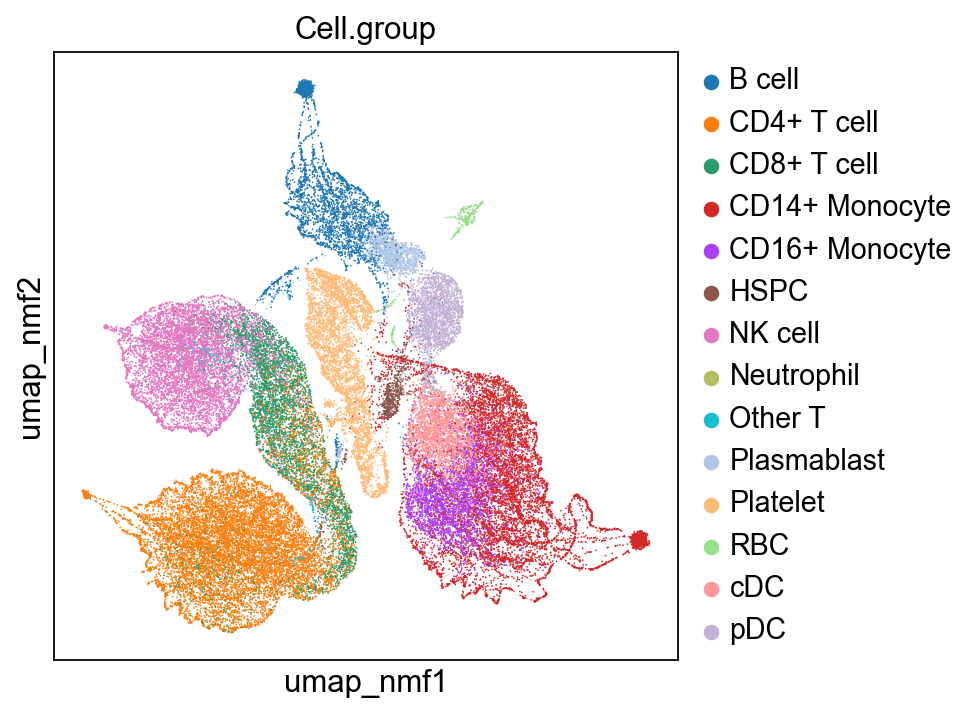

In [84]:
sc.pl.embedding(adata, basis='umap_nmf', color=['Cell.group'])

Definitely a bit wonky, but also definitely picking up on cell types.

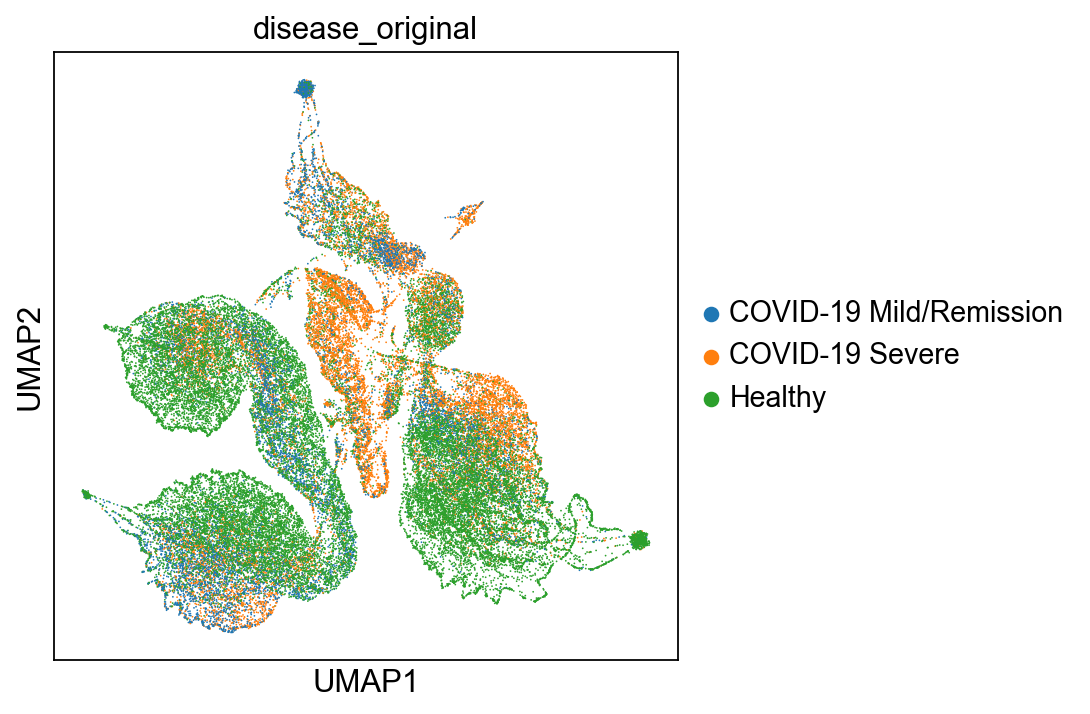

In [85]:
sc.pl.embedding(adata, basis='umap', color=['disease_original'])

## Explore the factors

Just look at some of the genes involved

In [96]:
nmf_output.nmf_module.model.var_names_hvg

array(['ENSG00000272622', 'ENSG00000181240', 'ENSG00000168229', ...,
       'ENSG00000204310', 'ENSG00000254614', 'ENSG00000256576'],
      dtype=object)

In [100]:
import pandas as pd

gene_name_lookup = adata.var['feature_name'].to_dict()

factor_df = pd.DataFrame(nmf_output.consensus[best_k]["consensus_D_kg"].t().numpy(), index=nmf_output.nmf_module.model.var_names_hvg)
factor_df['gene_name'] = factor_df.index.map(gene_name_lookup)
factor_df

0             1         2             3         4  \
ENSG00000272622  0.000030  0.000000e+00  0.000000  9.878830e-06  0.000000   
ENSG00000181240  0.000000  3.188711e-07  0.000000  7.540086e-07  0.000026   
ENSG00000168229  0.000000  0.000000e+00  0.000000  6.179109e-04  0.000000   
ENSG00000263677  0.000009  3.662180e-06  0.000154  3.529986e-05  0.000002   
ENSG00000148498  0.000724  0.000000e+00  0.000000  2.834601e-03  0.000000   
...                   ...           ...       ...           ...       ...   
ENSG00000138835  0.000000  5.785465e-04  0.000000  1.502665e-03  0.000000   
ENSG00000271717  0.000000  1.071846e-06  0.000003  3.649605e-07  0.000016   
ENSG00000204310  0.001264  1.217043e-03  0.000109  7.408815e-04  0.000359   
ENSG00000254614  0.002841  0.000000e+00  0.000000  1.620612e-03  0.000000   
ENSG00000256576  0.000000  2.171566e-04  0.000000  0.000000e+00  0.001120   

                        5         6        gene_name  
ENSG00000272622  0.000000  0.000094  ENSG00000272622  
ENSG00000181240  0.000016  0.000007         SLC25A41  
ENSG00000168229  0.003685  0.000000            PTGDR  
ENSG00000263677  0.000004  0.000011  ENSG00000263677  
ENSG00000148498  0.000000  0.000000            PARD3  
...                   ...       ...              ...  
ENSG00000138835  0.001901  0.000000             RGS3  
ENSG00000271717  0.000003  0.000008  ENSG00000271717  
ENSG00000204310  0.000461  0.000877           AGPAT1  
ENSG00000254614  0.000000  0.000115        CAPN1-AS1  
ENSG00000256576  0.000409  0.000035        LINC02361  

[2000 rows x 8 columns]

In [109]:
factor_df.sort_values(by=2, ascending=False).head(10)

0    1         2         3    4    5    6 gene_name
ENSG00000169877  0.000000  0.0  0.023099  0.000000  0.0  0.0  0.0      AHSP
ENSG00000143416  0.000000  0.0  0.022597  0.000000  0.0  0.0  0.0  SELENBP1
ENSG00000158578  0.000000  0.0  0.022568  0.000000  0.0  0.0  0.0     ALAS2
ENSG00000206177  0.000000  0.0  0.022233  0.000000  0.0  0.0  0.0       HBM
ENSG00000004939  0.000000  0.0  0.021858  0.000000  0.0  0.0  0.0    SLC4A1
ENSG00000166947  0.000000  0.0  0.021581  0.000000  0.0  0.0  0.0     EPB42
ENSG00000133742  0.000000  0.0  0.020771  0.000000  0.0  0.0  0.0       CA1
ENSG00000250361  0.000000  0.0  0.020587  0.000000  0.0  0.0  0.0      GYPB
ENSG00000204010  0.000000  0.0  0.019315  0.000000  0.0  0.0  0.0    IFIT1B
ENSG00000223609  0.000267  0.0  0.018806  0.000245  0.0  0.0  0.0       HBD

In [112]:
factor_df.sort_values(by=5, ascending=False).head(10)

0         1         2         3         4         5  \
ENSG00000229117  0.002421  0.013399  0.004392  0.000725  0.013253  0.010485   
ENSG00000251562  0.001721  0.011707  0.001394  0.000540  0.011897  0.010444   
ENSG00000133112  0.002916  0.013724  0.004912  0.000600  0.013558  0.010386   
ENSG00000137818  0.002310  0.012470  0.002596  0.000000  0.012059  0.009383   
ENSG00000156508  0.001449  0.011360  0.001300  0.000236  0.011215  0.008582   
ENSG00000100316  0.000066  0.008427  0.000621  0.000226  0.008980  0.007120   
ENSG00000105640  0.000000  0.009093  0.000959  0.000067  0.009034  0.006765   
ENSG00000051523  0.000033  0.008383  0.000000  0.000000  0.005222  0.006744   
ENSG00000142937  0.000000  0.009060  0.000801  0.000049  0.009010  0.006490   
ENSG00000105374  0.000023  0.001401  0.000070  0.000000  0.000308  0.005794   

                        6 gene_name  
ENSG00000229117  0.014523     RPL41  
ENSG00000251562  0.013238    MALAT1  
ENSG00000133112  0.013944      TPT1  
ENSG00000137818  0.013292     RPLP1  
ENSG00000156508  0.011948    EEF1A1  
ENSG00000100316  0.009762      RPL3  
ENSG00000105640  0.009981    RPL18A  
ENSG00000051523  0.007974      CYBA  
ENSG00000142937  0.009999      RPS8  
ENSG00000105374  0.000020      NKG7

In [113]:
factor_df.sort_values(by=6, ascending=False).head(10)

0         1         2         3         4         5  \
ENSG00000229117  0.002421  0.013399  0.004392  0.000725  0.013253  0.010485   
ENSG00000133112  0.002916  0.013724  0.004912  0.000600  0.013558  0.010386   
ENSG00000137818  0.002310  0.012470  0.002596  0.000000  0.012059  0.009383   
ENSG00000251562  0.001721  0.011707  0.001394  0.000540  0.011897  0.010444   
ENSG00000156508  0.001449  0.011360  0.001300  0.000236  0.011215  0.008582   
ENSG00000142937  0.000000  0.009060  0.000801  0.000049  0.009010  0.006490   
ENSG00000105640  0.000000  0.009093  0.000959  0.000067  0.009034  0.006765   
ENSG00000100316  0.000066  0.008427  0.000621  0.000226  0.008980  0.007120   
ENSG00000105369  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ENSG00000166441  0.000000  0.007830  0.000606  0.000253  0.007453  0.005558   

                        6 gene_name  
ENSG00000229117  0.014523     RPL41  
ENSG00000133112  0.013944      TPT1  
ENSG00000137818  0.013292     RPLP1  
ENSG00000251562  0.013238    MALAT1  
ENSG00000156508  0.011948    EEF1A1  
ENSG00000142937  0.009999      RPS8  
ENSG00000105640  0.009981    RPL18A  
ENSG00000100316  0.009762      RPL3  
ENSG00000105369  0.008456     CD79A  
ENSG00000166441  0.008147    RPL27A

## Project factors back to all genes

Now refit for all genes, not just the highly variable genes. In cNMF this involves solving an auxiliary linear regression problem.

In [ ]:
full_D_kg = getattr(pipeline[-1], f"full_D_{best_k}_kg")
full_D_kg = full_D_kg.cpu().numpy()

full_D_kg = pd.DataFrame(full_D_kg)
full_D_kg.columns = adata.var.index
full_D_kg = full_D_kg.T

## Results as a summary anndata

The results can be packaged up into an anndata object if desired, and perhaps saved that way as an h5ad file.

Here we omit the actual count matrix, since in theory it is too big to fit in memory.